In [25]:
import pandas as pd
import numpy as np
import torch

In [26]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    runs_on_gpu = True
    from google.colab import drive
    drive.mount('/content/drive')
    directory = 'drive/MyDrive/'
else:
    device = torch.device('cpu')
    runs_on_gpu = False
    directory = ''
print(f"Runs on {device.type}")

Runs on cpu


In [27]:
data = pd.read_json('preprocessed_recipes.json')
print(data.info())
interesting_columns = ['num_categories', 'num_ingredients', 'num_directions', 'numerical_columns']
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 20100 entries, 0 to 20099
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   directions         20100 non-null  object        
 1   date               20100 non-null  datetime64[ns]
 2   categories         20100 non-null  object        
 3   desc               20100 non-null  object        
 4   rating             20100 non-null  float64       
 5   title              20100 non-null  object        
 6   ingredients        20100 non-null  object        
 7   num_categories     20100 non-null  int64         
 8   num_ingredients    20100 non-null  int64         
 9   num_directions     20100 non-null  int64         
 10  numerical_columns  20100 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 1.8+ MB
None


,directions,date,categories,desc,rating,title,ingredients,num_categories,num_ingredients,num_directions,numerical_columns
0,"1. Place the stock, lentils, celery, carrot, t...",2006-09-01 04:00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",11,15,3,-0.034044
1,Combine first 9 ingredients in heavy medium sa...,2004-08-20 04:00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",This uses the same ingredients found in boudin...,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",11,28,5,-0.033669
2,In a large heavy saucepan cook diced fennel an...,2004-08-20 04:00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",,3.750,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk...",7,6,2,-0.037781
3,Heat oil in heavy large skillet over medium-hi...,2009-03-27 04:00:00,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",The Sicilian-style tomato sauce has tons of Me...,5.000,Mahi-Mahi in Tomato Olive Sauce,"[2 tablespoons extra-virgin olive oil, 1 cup c...",17,10,2,-0.000106
4,Preheat oven to 350°F. Lightly grease 8x8x2-in...,2004-08-20 04:00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",,3.125,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th...",11,6,1,-0.034548


In [28]:
def load_tfidf():
    return pd.read_pickle('tfidf.pkl')

def load_word2vec():
    return np.load("word2vec.npy")

def load_context_embedding():
    return np.load("context_embedding.npy")

# 3 Basic Project
The basic project will consist of solving a regression task, comparing the performance obtained using different vectorizations of the documents and at least two different machine learning strategies, as described below. 

You should use the information in the directions and/or desc variables for all steps of the project, possibly combining this information with metadata from other variables. You should use appropriate metrics for evaluating this task. The performance of the different methods should be estimated using a validation methodology, which you should also explain in the documentation. You should provide a description of the methodology used and analyze the performance obtained according to the input variables.
Keep in mind that the goal is to describe the work carried out and critically analyze the results obtained. Support this with graphs or other representations you consider appropriate. There is no need to describe the algorithms used, but you should explain how you tuned their parameters.

## Baseline

In [29]:
mean_rating = np.mean(data['rating'])
baseline_mse = np.mean((data['rating'] - mean_rating)**2)
print(f"Mean rating: {mean_rating} and MSE: {baseline_mse}")

Mean rating: 3.7130597014925373 and MSE: 1.8039448048934432


In [30]:
most_used_rating = 4.375
mse = np.mean((data['rating'] - most_used_rating)**2)
print(f"MSE: {mse}")

MSE: 2.242109763681592


## 3.4
Training and evaluation of regression models using at least the following two machine learning strategies:
- Neural networks using PyTorch for implementation.
- At least one other technique implemented in the Scikit-learn library
(e.g., K-NN, SVM, Random Forest, etc.)

### Neural networks using PyTorch for implementation.

In [31]:
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import seaborn as sns

In [38]:
class Model(nn.Module): #this is the model we will use
    def __init__(self, input_size):
        super(Model, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, int(input_size/2)),
            nn.ReLU(),
            nn.Linear(int(input_size/2), 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            #nn.Linear(128, 8),
            #nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        return self.linear_relu_stack(x)

In [53]:
X = load_context_embedding()

In [54]:
def print_state(epoch, num_epochs, loss, model, X_test, y_test, loss_function, hist):
    print(f'Epoch {epoch}/{num_epochs}')
    print(f'-- Loss: {loss.item():.4f}')

    with torch.no_grad():
        model.eval()
        test_outputs = torch.round(model(X_test))
    
    test_loss = loss_function(test_outputs, y_test)
    print(f'-- Final test mse: {test_loss.item():.4f}')
    print(f"-- Compared to baseline mse: {baseline_mse / test_loss * 100:.0f}%")
    hist[0].append(loss.item())
    hist[1].append(test_loss.item())

def neural_network(X, y):
    # this is the history of the training to plot later
    hist = (list(), list())

    #prepare the data
    X_train, X_test, y_train, y_test = list(map(lambda x: torch.FloatTensor(x), train_test_split(X, y, test_size=0.2, random_state=42)))
    y_train = torch.FloatTensor(y_train).unsqueeze(1)
    y_test = torch.FloatTensor(y_test).unsqueeze(1)

    #initialize the model and the optimizer
    model = Model(X_train.shape[1])
    loss_function = nn.MSELoss()
    adam_optimizer = optim.Adam(model.parameters(), lr=0.001)

    #training loop
    num_epochs = 1000
    for epoch in range(num_epochs):
        outputs = model(X_train)
        
        loss = loss_function(outputs, y_train)
        
        adam_optimizer.zero_grad()
        loss.backward()
        adam_optimizer.step()

        if (epoch % 10 == 0):
            print_state(epoch, num_epochs, loss, model, X_test, y_test, loss_function, hist)

    print_state(epoch, num_epochs, loss, model, X_test, y_test, loss_function, hist)
    return hist
    

In [55]:
hist = neural_network(X, data['rating'].to_numpy())

Epoch 0/1000
-- Loss: 15.2658
-- Final test mse: 15.4966
-- Compared to baseline mse: 12%
Epoch 10/1000
-- Loss: 4.4277
-- Final test mse: 3.1843
-- Compared to baseline mse: 57%
Epoch 20/1000
-- Loss: 2.1947
-- Final test mse: 2.1028
-- Compared to baseline mse: 86%
Epoch 30/1000
-- Loss: 1.6698
-- Final test mse: 1.7947
-- Compared to baseline mse: 101%
Epoch 40/1000
-- Loss: 1.6852
-- Final test mse: 1.7625
-- Compared to baseline mse: 102%
Epoch 50/1000
-- Loss: 1.6813
-- Final test mse: 1.7433
-- Compared to baseline mse: 103%
Epoch 60/1000
-- Loss: 1.6331
-- Final test mse: 1.6915
-- Compared to baseline mse: 107%
Epoch 70/1000
-- Loss: 1.6262
-- Final test mse: 1.6787
-- Compared to baseline mse: 107%
Epoch 80/1000
-- Loss: 1.6179
-- Final test mse: 1.6787
-- Compared to baseline mse: 107%
Epoch 90/1000
-- Loss: 1.6117
-- Final test mse: 1.6731
-- Compared to baseline mse: 108%
Epoch 100/1000
-- Loss: 1.6057
-- Final test mse: 1.6700
-- Compared to baseline mse: 108%
Epoch 110/1

<Axes: >

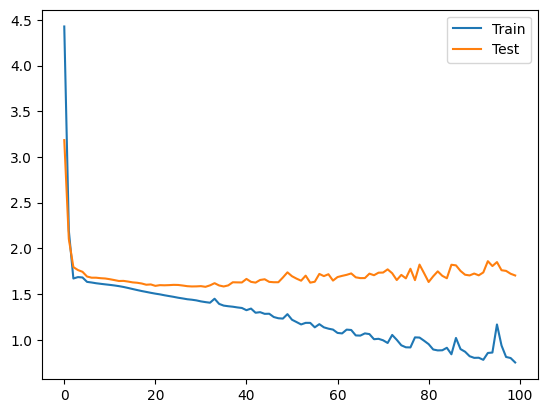

In [56]:
sns.lineplot(x=range(len(hist[0][1:])), y=hist[0][1:], label='Train')
sns.lineplot(x=range(len(hist[1][1:])), y=hist[1][1:], label='Test')

### - At least one other technique implemented in the Scikit-learn library
(e.g., K-NN, SVM, Random Forest, etc.)

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

In [58]:
def fit_and_evaluate(model, X, y):
    scores = cross_val_score(model, X, y, cv=2, scoring='neg_mean_squared_error')
    mean_score = scores.mean() * -1
    print(f'-- Mean MSE: {mean_score}')
    print(f"-- Compared to baseline mse: {baseline_mse / mean_score * 100:.0f}%")

In [59]:
data_configs = {
    'interesting_columns': data[interesting_columns],
    'tfidf': load_tfidf(),
    'word2vec': load_word2vec(),
    'context_embedding': load_context_embedding(),
}

models = [GradientBoostingRegressor()] 
for model in models:
    for key, X in data_configs.items():
        print(f"{model} with {key}")
        fit_and_evaluate(model, X, data['rating'])

GradientBoostingRegressor() with interesting_columns
-- Mean MSE: 1.6609051640225028
-- Compared to baseline mse: 109%
GradientBoostingRegressor() with tfidf
-- Mean MSE: 1.5411751709753745
-- Compared to baseline mse: 117%
GradientBoostingRegressor() with word2vec
-- Mean MSE: 1.681350425842794
-- Compared to baseline mse: 107%
GradientBoostingRegressor() with context_embedding
-- Mean MSE: 1.5304366199453243
-- Compared to baseline mse: 118%


## 3.5
Comparison of the results obtained in step 3 with fine-tuning a pre-trained model from Hugging Face. In this step, you are asked to use a transformer model with a regression head.

Tutorial used: https://discuss.huggingface.co/t/how-to-set-up-trainer-for-a-regression/12994

In [11]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split  

In [28]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# we put number of labels to 1 because we are doing regression
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
X = data['directions'].tolist()
y = data['rating'].to_numpy(dtype='float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train = tokenizer(X_train, truncation=True, padding=True, max_length=128)
X_test = tokenizer(X_test, truncation=True, padding=True, max_length=128)

In [30]:
# we need to transform the data to tensors so we can use them in pytorch
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.X.items()}
        item['labels'] = torch.tensor(self.y[idx])
        return item

    def __len__(self):
        return len(self.y)

train_dataset = Dataset(X_train, y_train)
test_dataset = Dataset(X_test, y_test)

Start training


                                        
  0%|          | 0/3015 [05:41<?, ?it/s]         

{'loss': 13.6354, 'grad_norm': 110.56185913085938, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}


                                        
  0%|          | 0/3015 [05:44<?, ?it/s]         

{'loss': 12.4936, 'grad_norm': 127.78746032714844, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.02}


                                        
  0%|          | 0/3015 [05:48<?, ?it/s]         

{'loss': 10.6723, 'grad_norm': 95.80782318115234, 'learning_rate': 3e-06, 'epoch': 0.03}


                                        
  0%|          | 0/3015 [05:51<?, ?it/s]         

{'loss': 8.7736, 'grad_norm': 114.6506118774414, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.04}


                                        
  0%|          | 0/3015 [05:55<?, ?it/s]         

{'loss': 7.0099, 'grad_norm': 84.49993896484375, 'learning_rate': 5e-06, 'epoch': 0.05}


KeyboardInterrupt: 

In [ ]:
training_args = TrainingArguments(
    output_dir=directory+'results',
    num_train_epochs=3,
    per_device_train_batch_size=64, #batch size can be bigger for the used gpu
    per_device_eval_batch_size=64, 
    warmup_steps=500,
    weight_decay=0.01, 
    logging_dir=directory+'logs',
    logging_steps=10,
    report_to=[],
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

In [ ]:
trainer.train()
model.save_pretrained(directory+'fine-tuned-bert')
tokenizer.save_pretrained(directory+'fine-tuned-bert')

<Axes: >

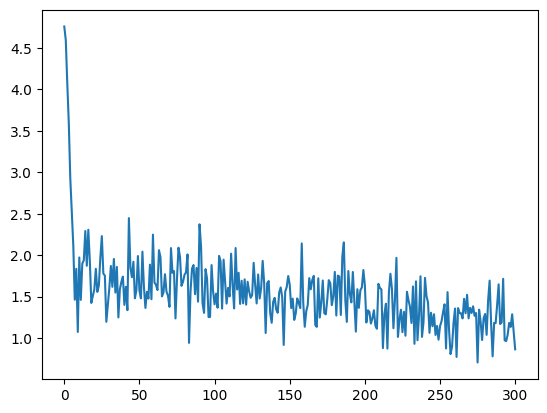

In [60]:
results = [
    4.759500, 4.596200, 4.074600, 3.601100, 2.927900, 2.513100, 2.120000, 
    1.463200, 1.835600, 1.074400, 1.972900, 1.461300, 1.899600, 1.938900, 
    2.292000, 1.872600, 2.307200, 1.933600, 1.424500, 1.509400, 1.586800, 
    1.836600, 1.557700, 1.632400, 1.969700, 2.230800, 1.778300, 1.754300, 
    1.196500, 1.406600, 1.609700, 1.870100, 1.618300, 1.954900, 1.549400, 
    1.859000, 1.249100, 1.589800, 1.678700, 1.741700, 1.400900, 1.618800, 
    1.336800, 2.447800, 1.850800, 1.734400, 1.921000, 1.480700, 1.579100, 
    1.990500, 1.573000, 1.479700, 2.043300, 1.617300, 1.363900, 1.558400, 
    1.477300, 1.886400, 1.468900, 2.248400, 1.670100, 1.643600, 1.579900, 
    2.060900, 1.977900, 1.503400, 1.549900, 1.771000, 1.562300, 1.511200, 
    1.377100, 2.086200, 1.787400, 1.807900, 1.237400, 1.720100, 2.090700, 
    1.979700, 1.630400, 1.679800, 1.763900, 1.793200, 2.009800, 0.942700, 
    1.564700, 1.839600, 1.881600, 1.529500, 1.846800, 1.439600, 2.372700, 
    2.105600, 1.419600, 1.304600, 1.831700, 1.720400, 1.254000, 1.254900, 
    1.881200, 1.566800, 1.408300, 1.536700, 1.366900, 1.991900, 1.925700, 
    1.355900, 1.946600, 1.687000, 1.416600, 1.605900, 1.503000, 2.018900, 
    1.634700, 1.358600, 2.086900, 1.586500, 1.788300, 1.412300, 1.692000, 
    1.419300, 1.708600, 1.403500, 1.679500, 1.564100, 1.486100, 1.518400, 
    1.908500, 1.640100, 1.418400, 1.767100, 1.477200, 1.606800, 1.931800, 
    1.662900, 1.061500, 1.663100, 1.688200, 1.301500, 1.184800, 1.439600, 
    1.486000, 1.344500, 1.305700, 1.550200, 1.611000, 1.494300, 0.917500, 
    1.561000, 1.616100, 1.748800, 1.644600, 1.362600, 1.476500, 1.219800, 
    1.296100, 1.478700, 1.424600, 1.362100, 2.142400, 1.426600, 1.136900, 
    1.325600, 1.400400, 1.724100, 1.589100, 1.700800, 1.751100, 1.159100, 
    1.135800, 1.721500, 1.248000, 1.430000, 1.695100, 1.299600, 1.287200, 
    1.467800, 1.699100, 1.662400, 1.397900, 1.504900, 1.798800, 1.272500, 
    1.754300, 1.743300, 1.279200, 1.985400, 2.155000, 1.452800, 1.195800, 
    1.809400, 1.532700, 1.430900, 1.797800, 1.429000, 1.078200, 1.589500, 
    1.365400, 1.578100, 1.612000, 1.821400, 1.633700, 1.188200, 1.335900, 
    1.318100, 1.176000, 1.236900, 1.335800, 1.150800, 1.112700, 1.655000, 
    1.604600, 1.587000, 0.879600, 1.292700, 1.414900, 0.873300, 1.559500, 
    1.776100, 1.593700, 1.119800, 1.465400, 1.968100, 1.014400, 1.221700, 
    1.342500, 1.071600, 1.317800, 1.029000, 1.558400, 1.458600, 1.379700, 
    1.182600, 1.623100, 0.931300, 1.685000, 0.974200, 1.261800, 1.745800, 
    1.014900, 1.189500, 1.727300, 1.504600, 1.432500, 1.064100, 1.306000, 
    1.143100, 1.287800, 1.038200, 1.146300, 0.981500, 1.144800, 1.203100, 
    1.311900, 1.407600, 0.875600, 1.554500, 1.102300, 0.807700, 0.897500, 
    1.186600, 1.357000, 0.773000, 1.362100, 1.302200, 1.299400, 1.237400, 
    1.473900, 1.299600, 1.522500, 1.238400, 1.365200, 1.303200, 1.383900, 
    1.268900, 1.302600, 0.706100, 1.342800, 1.201400, 0.977100, 1.239500, 
    1.291500, 1.039400, 1.454600, 1.693900, 1.171200, 0.780100, 1.183500, 
    1.180300, 1.401500, 1.648700, 1.170000, 1.188800, 1.715400, 0.973500, 
    0.963600, 1.040900, 1.183600, 1.135000, 1.287700, 1.070800, 0.864700
]
sns.lineplot(x=range(len(results)), y=results)


In [ ]:
trainer.evaluate()

{'eval_loss': 1.5266793966293335,
 'eval_runtime': 26.9099,
 'eval_samples_per_second': 149.388,
 'eval_steps_per_second': 2.341,
 'epoch': 3.0}